In [2]:
#import cv2
import copy

import pykitti
from matplotlib import pyplot as plt
import numpy as np
from open3d import *
from open3d import open3d as op


In [3]:

basedir = '/home/kish/dataset'


sequence = '00'
dataset = pykitti.odometry(basedir, sequence, frames=range(0, 20, 5))
print(dataset.sequence_path)

# Grab some data
second_pose = dataset.poses[1]
#print(second_pose)
third_velo = dataset.get_velo(0)

/home/kish/dataset/sequences/00


In [4]:

'''
# Display some of the data
np.set_printoptions(precision=4, suppress=True)

f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')

plt.show()
'''
pcd = read_point_cloud("000000.pcd")
pcd1 = read_point_cloud("000001.pcd")
pcd2 = read_point_cloud("000002.pcd")
pcd3 = read_point_cloud("000003.pcd")
draw_geometries([pcd])
#draw_geometries([pcd1])
#draw_geometries([pcd2])
#draw_geometries([pcd3])


In [5]:
draw_geometries([pcd, pcd1, pcd2, pcd3])
#pcd = op.PointCloud()
#op.KDTreeSearchParam
#(third_velo)
# pcd.points = Vector3dVector(third_velo) - Unable to cast Python instance to C++ type


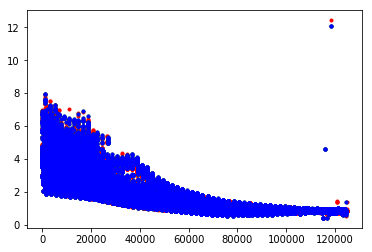

In [6]:

#print(op.compute_point_cloud_mahalanobis_distance(pcd))
plt.plot(op.compute_point_cloud_mahalanobis_distance(pcd),'.r')
plt.plot(op.compute_point_cloud_mahalanobis_distance(pcd1), '.g')
plt.plot(op.compute_point_cloud_mahalanobis_distance(pcd1), '.b')
plt.show()



In [7]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    draw_geometries([source_temp, target_temp])


In [8]:
threshold = 0.02
trans_init = np.asarray(
    [[0.862, 0.011, -0.507, 0.5],
     [-0.139, 0.967, -0.215, 0.7],
     [0.487, 0.255, 0.835, -1.4],
     [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(pcd, pcd1, trans_init)


In [9]:
draw_registration_result(pcd, pcd3, trans_init)

In [11]:
source = pcd
target = pcd1

reg_p2p = registration_icp(source, target, threshold, trans_init,
            TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("")
draw_registration_result(source, target, reg_p2p.transformation)

print("Apply point-to-plane ICP")
reg_p2l = registration_icp(source, target, threshold, trans_init,
            TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("")
draw_registration_result(source, target, reg_p2l.transformation)

RegistrationResult with fitness = 0.000858, inlier_rmse = 0.014886, and correspondence_set size of 107
Access transformation to get result.
Transformation is:
[[ 0.86239763  0.01170163 -0.50630604  0.49614753]
 [-0.13937863  0.96701051 -0.2147076   0.70208109]
 [ 0.48618713  0.2549289   0.83549616 -1.39143413]
 [ 0.          0.          0.          1.        ]]

Apply point-to-plane ICP
RegistrationResult with fitness = 0.000000, inlier_rmse = 0.000000, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.862  0.011 -0.507  0.5  ]
 [-0.139  0.967 -0.215  0.7  ]
 [ 0.487  0.255  0.835 -1.4  ]
 [ 0.     0.     0.     1.   ]]



In [12]:
print("Testing kdtree in open3d ...")
print("Load a point cloud and paint it gray.")
pcd.paint_uniform_color([0.5, 0.5, 0.5])
pcd_tree = KDTreeFlann(pcd)
print("Paint the 1500th point red.")
pcd.colors[1500] = [1, 0, 0]
draw_geometries([pcd])
print("Find its neighbors with distance less than 0.2, paint green.")
[k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[1500], 0.2)
np.asarray(pcd.colors)[idx[1:], :] = [0, 1, 0]
print("Find its 200 nearest neighbors, paint blue.")
[k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[1500], 200)
np.asarray(pcd.colors)[idx[1:], :] = [0, 0, 1]
print("Find its neighbors with distance less than 0.2, paint green.")
[k, idx, _] = pcd_tree.search_radius_vector_3d(pcd.points[1500], 0.2)
np.asarray(pcd.colors)[idx[1:], :] = [0, 1, 0]
draw_geometries([pcd])

Testing kdtree in open3d ...
Load a point cloud and paint it gray.
Paint the 1500th point red.
Find its neighbors with distance less than 0.2, paint green.
Find its 200 nearest neighbors, paint blue.
Find its neighbors with distance less than 0.2, paint green.


In [36]:
def execute_global_registration(
        source_down, target_down, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh,
            distance_threshold,
            TransformationEstimationPointToPoint(False), 4,
            [CorrespondenceCheckerBasedOnEdgeLength(0.9),
            CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            RANSACConvergenceCriteria(4000000, 500))
    return result

In [22]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = voxel_down_sample(pcd, voxel_size)
    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    estimate_normals(pcd_down, KDTreeSearchParamHybrid(
            radius = radius_normal, max_nn = 30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = compute_fpfh_feature(pcd_down,
            KDTreeSearchParamHybrid(radius = radius_feature, max_nn = 100))
    return pcd_down, pcd_fpfh

In [18]:
def prepare_dataset(voxel_size, source, target):
    print(":: Load two point clouds and disturb initial pose.")
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0],
                            [1.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh


In [16]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = registration_icp(source, target, distance_threshold,
            result_ransac.transformation,
            TransformationEstimationPointToPlane())
    return result

In [38]:
voxel_size = 0.2
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, pcd1,pcd2)
result_ransac = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
print((result_ransac))
draw_registration_result(source_down, target_down,result_ransac.transformation)
result_icp = refine_registration(source, target, source_fpfh, target_fpfh, voxel_size)
draw_registration_result(source, target, result_icp.transformation)


:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.200.
:: Estimate normal with search radius 0.400.
:: Compute FPFH feature with search radius 1.000.
:: Downsample with a voxel size 0.200.
:: Estimate normal with search radius 0.400.
:: Compute FPFH feature with search radius 1.000.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.200,
   we use a liberal distance threshold 0.300.
RegistrationResult with fitness = 0.842878, inlier_rmse = 0.135057, and correspondence_set size of 26522
Access transformation to get result.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.080.


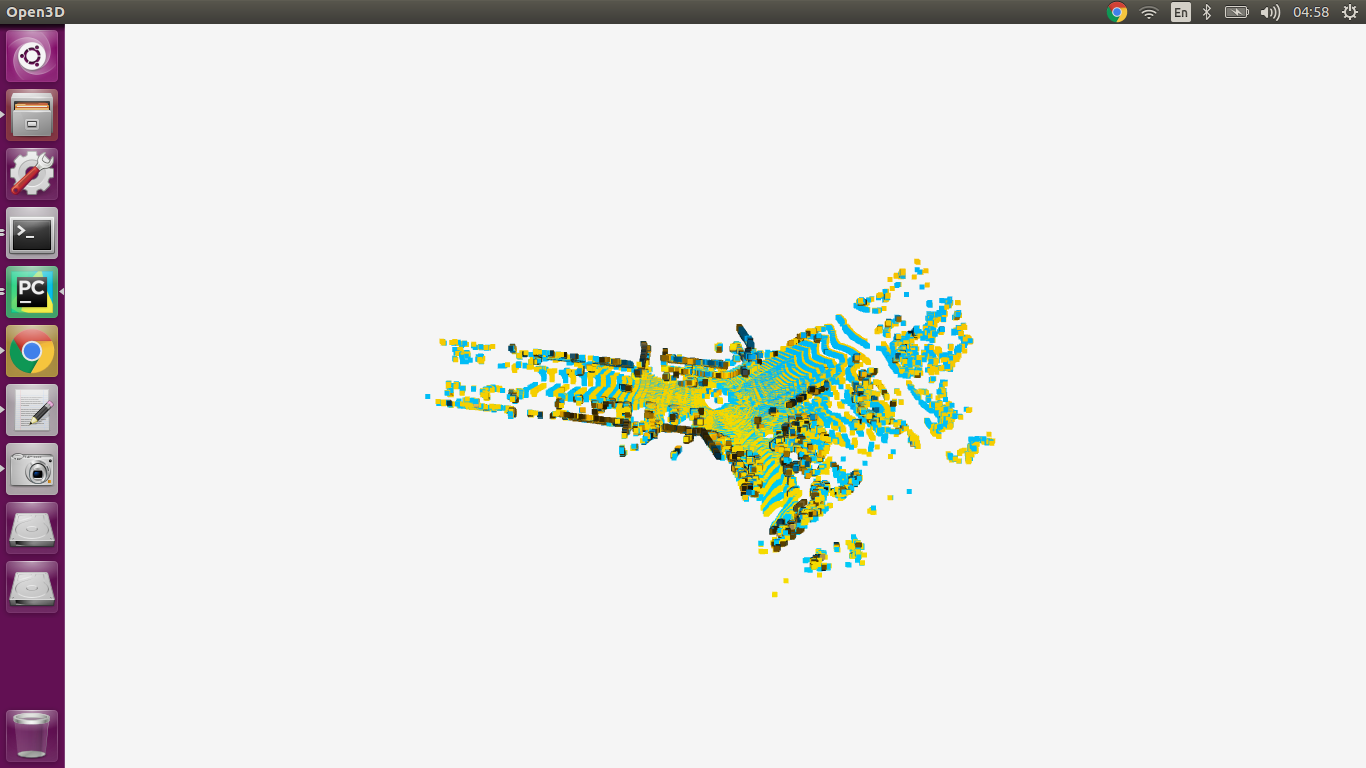